# 1. Prepare

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import math
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imread, imsave, figure
import pandas as pd
import numpy as np
import sys
import os
from skimage.color import rgb2gray
from skimage.transform import rescale, resize
import seaborn as sns

#Keras:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

#Custom Functions:
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

from imports.utils.log_progress import log_progress
from imports.utils.visualization import Visualize, Evaluate
from imports.models.data_generator import DataGenerator
from imports.utils.enums import DATA_BASE_PATH, SHAPE
from imports.models.u_net import get_unet, get_unet_mod
from imports.models.u_net import UNet
from imports.utils.utils import rle_encode, rle_decode

DATA_IMAGE_PATH = DATA_BASE_PATH + '/Images'
DATA_MASK_PATH = DATA_BASE_PATH + '/Masks'

SHAPE = (512,768)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [3]:
import warnings
warnings.filterwarnings("ignore")

### Check if GPU available:

In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

### Load Splited Data

In [5]:
train80_df = pd.read_pickle(DATA_BASE_PATH+'/train_df')
val20_df = pd.read_pickle(DATA_BASE_PATH+'/val_df')

print("Number of training Samples:", len(train80_df))
print("Number of validation Samples:", len(val20_df))

Number of training Samples: 405
Number of validation Samples: 102


In [7]:
train20_df = train80_df[0:102]
val80_df = val20_df.append(train80_df[102::])
print("Number of training Samples:", len(train20_df))
print("Number of validation Samples:", len(val80_df))

Number of training Samples: 102
Number of validation Samples: 405


In [ ]:
mergedStuff = pd.merge(new_train_df, new_val_df, on=['name'], how='inner')
mergedStuff.head()

# 3 Training:

### 3.1 Load UNet Model:

Pretrained UNet:

In [8]:
unet = UNet()
unet.create_pretrained_model(encoder_type="vgg19",batchnorm=False,coord_conv=False,input_shape=(512, 768, 3))
model = unet.get_model()
unet.freeze_encoder(model)
model = unet.get_model()
model.summary()

80142336/80134624 [==============================] - 50s 1us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 768, 3)  0                                            
__________________________________________________________________________________________________
d10 (Conv2D)                    (None, 512, 768, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
d11 (Conv2D)                    (None, 512, 768, 64) 36928       d10[0][0]                        
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 384, 64) 0           d11[0][0]                        
___________________________________________

### 3.2 Define Train- Generator:

In [9]:
params = {'target_size': SHAPE,
          'batch_size': 4,
          'input_channels': 3,
          'shuffle': True}

# Generators
sample_gen = DataGenerator(df=train80_df,hist_equal=True,augment_data=True,save_images=False,**params)
i_sample = iter(sample_gen)

Found 405 Files


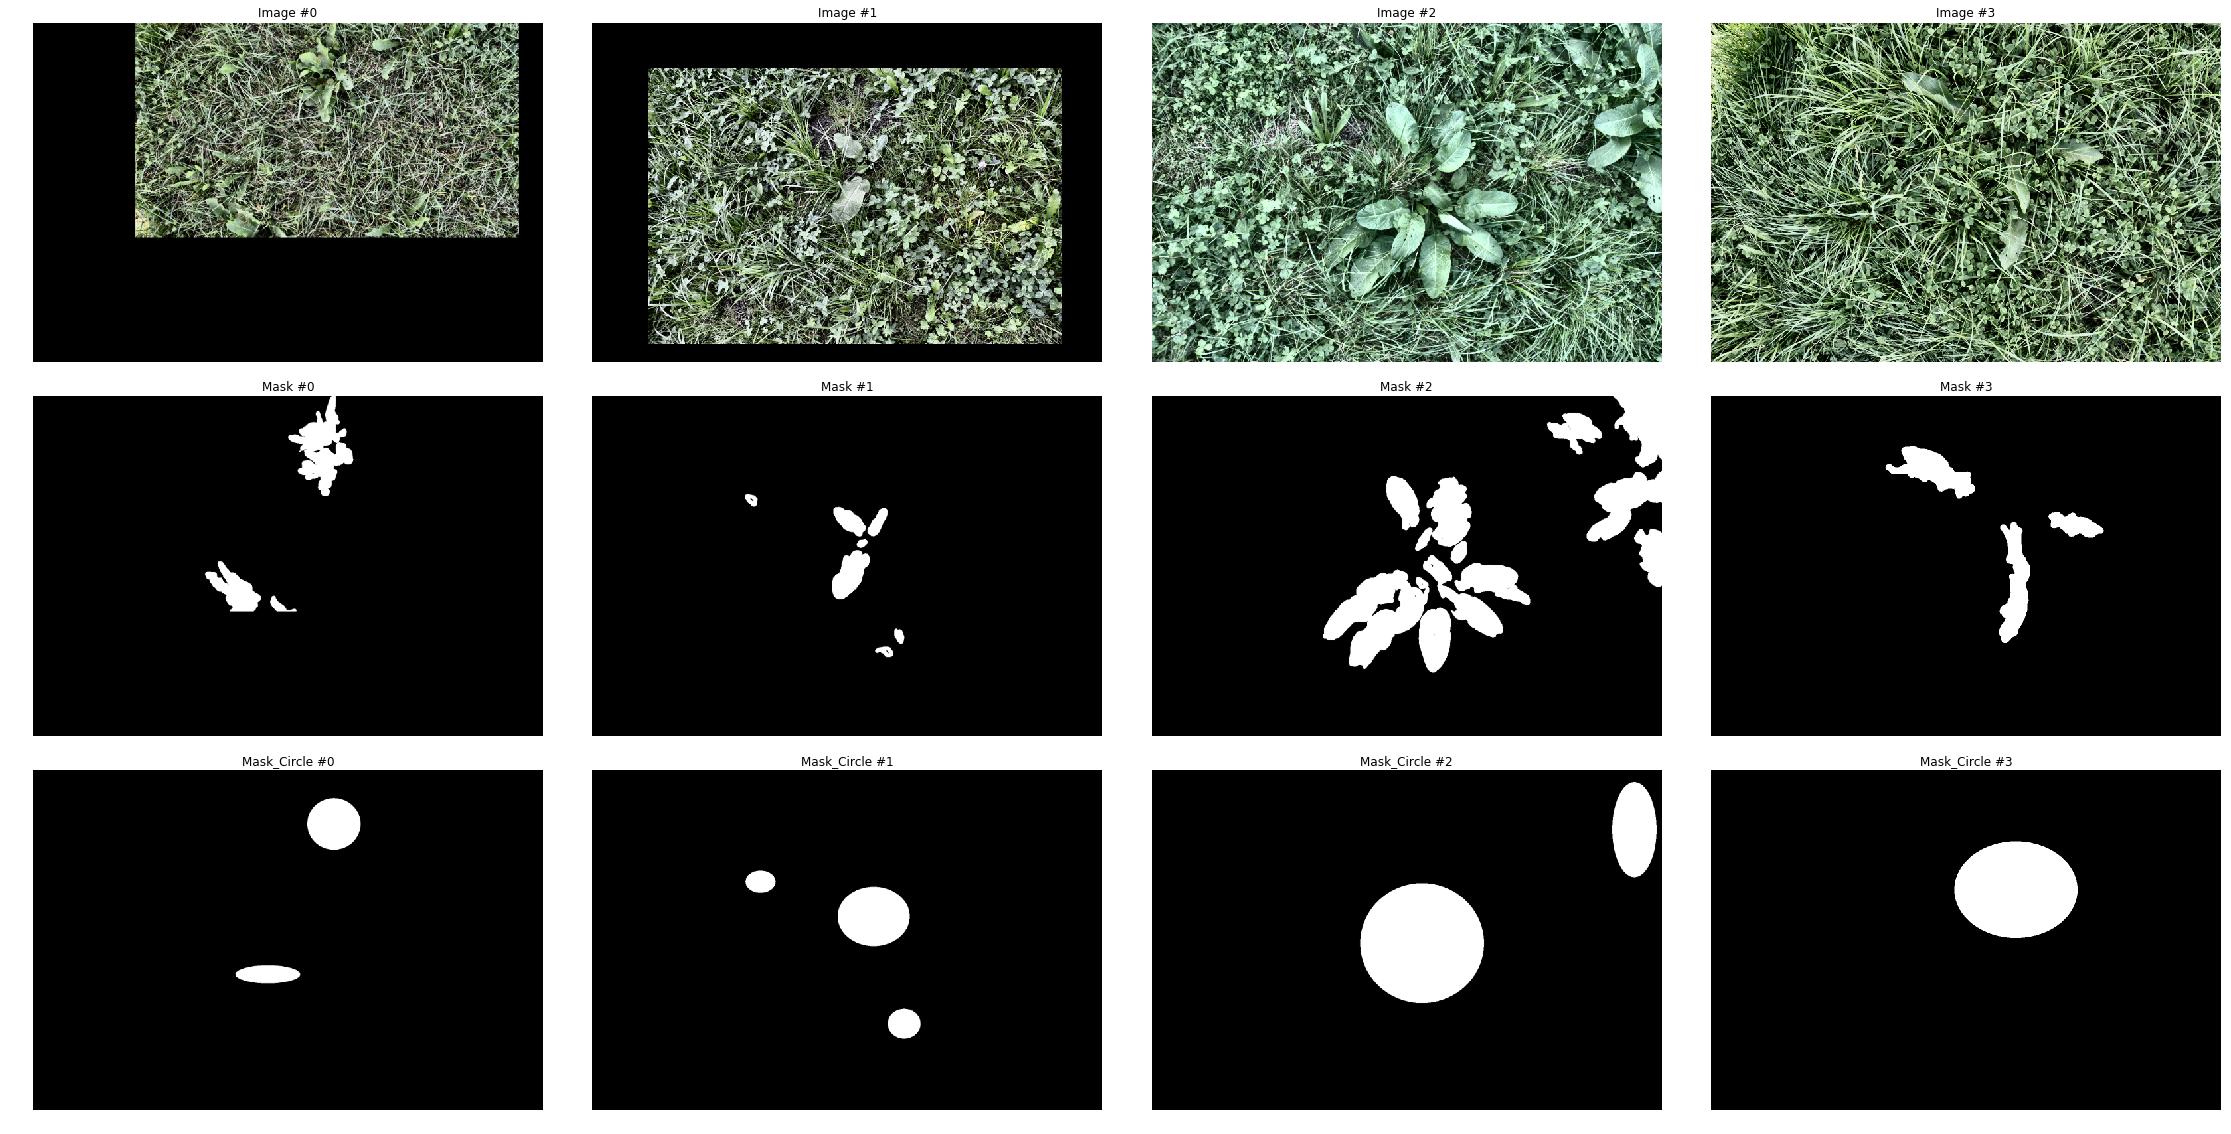

In [10]:
imgs,msks = next(i_sample)
plt.figure(figsize=(40,20))
x,y =4,1
for i in range(y):
    for j in range(x):
        plt.subplot(y*3,x,i*2*x+j+1)
        pos = i+j
        plt.imshow(imgs[pos,:,:,:].reshape(*SHAPE,3))
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*3,x,(i*2+1)*x+j+1)
        plt.imshow(msks[pos,:,:,0].reshape(SHAPE),cmap='gray')
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*3,x,(i*2+2)*x+j+1)
        plt.imshow(msks[pos,:,:,1].reshape(SHAPE),cmap='gray')
        plt.title('Mask_Circle #{}'.format(pos))
        plt.axis('off')
        
plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.show()

In [11]:
print(imgs.shape)
print(msks.shape)
print(imgs.max())
print(msks.max())

(4, 512, 768, 3)
(4, 512, 768, 2)
1.0
1.0


### 3.5 Train:

In [12]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard

BS = 3
import math
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.1
    epochs_drop = 20.0
    lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    print("Learning Rate: " + str(lrate))
    return lrate

lrate = LearningRateScheduler(step_decay)


checkpoint = ModelCheckpoint('best_model.h5', 
                             monitor='val_dice_coeff', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coeff', 
                                   factor=0.1, 
                                   patience=6, 
                                   verbose=1, 
                                   mode='max', 
                                   epsilon=0.0001, 
                                   cooldown=6, 
                                   min_lr=0.0001)

early = EarlyStopping(monitor="val_dice_coeff", 
                      mode="max", 
                      patience=18,
                      restore_best_weights=True)

tensorboard = TensorBoard(log_dir='../docs/tensorboard2', 
                            histogram_freq=0, 
                            batch_size=BS*4, 
                            write_graph=True, 
                            write_grads=True, 
                            write_images=True, 
                            embeddings_freq=0, 
                            embeddings_layer_names=None, 
                            embeddings_metadata=None, 
                            embeddings_data=None, 
                            update_freq='epoch')

callbacks_list = [early,checkpoint,lrate,tensorboard]

In [13]:
params = {'target_size': (512,768),
          'batch_size': 3,
          'input_channels': 3,
          'shuffle': True}

# Generators
training_generator = DataGenerator(df=train80_df,hist_equal=True,augment_data=True,save_images=False,**params)
validation_generator = DataGenerator(df=val20_df,hist_equal=True,**params)

Found 405 Files
Found 102 Files


In [ ]:
H = model.fit_generator(
    training_generator,
    steps_per_epoch=len(train80_df)*1 // BS,
    validation_data=validation_generator,
    validation_steps=len(val20_df) // BS,
    epochs=2,
    verbose=1,
    use_multiprocessing=True,
    workers=8,
    callbacks=callbacks_list)

In [15]:
unet.unfreeze_encoder(model)
model = unet.get_model()

In [ ]:
%%time
H2 = model.fit_generator(
    training_generator,
    steps_per_epoch=len(train80_df)*1 // BS,
    validation_data=validation_generator,
    validation_steps=len(val20_df) // BS,
    epochs=50,
    verbose=1,
    use_multiprocessing=True,
    workers=8,
    callbacks=callbacks_list)

### Training Stats

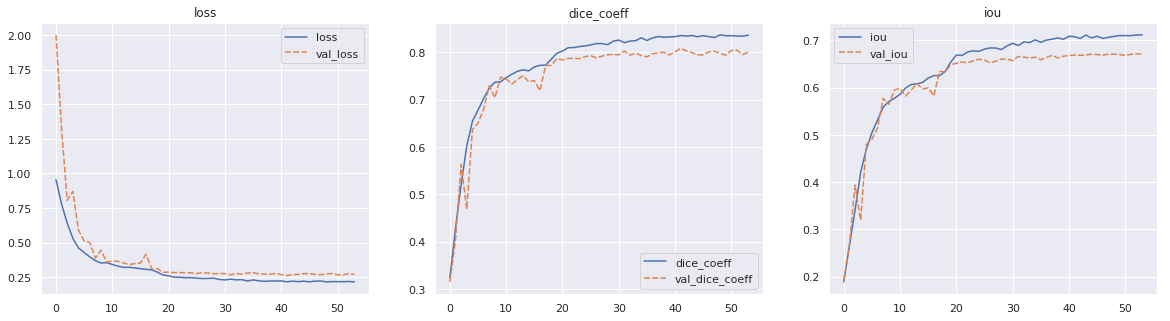

In [36]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
data = {#"epochs":np.linspace(0,len(H.history['dice_coeff']),len(H.history['dice_coeff'])),
        "loss":H2.history['loss'],
        "val_loss":H2.history['val_loss']}
loss_data = pd.DataFrame.from_dict(data)
sns.set(style="darkgrid")
ax = sns.lineplot(data=loss_data).set_title("loss")

plt.subplot(1,3,2)
data = {#"epochs":np.linspace(0,len(H.history['dice_coeff']),len(H.history['dice_coeff'])),
        "dice_coeff":H2.history['dice_coeff'],
        "val_dice_coeff":H2.history['val_dice_coeff']}
dice_data = pd.DataFrame.from_dict(data)
sns.set(style="darkgrid")
ax = sns.lineplot(data=dice_data).set_title("dice_coeff")

plt.subplot(1,3,3)
data = {#"epochs":np.linspace(0,len(H.history['dice_coeff']),len(H.history['dice_coeff'])),
        "iou":H2.history['iou_score'],
        "val_iou":H2.history['val_iou_score']}
iou_data = pd.DataFrame.from_dict(data)
sns.set(style="darkgrid")
ax = sns.lineplot(data=iou_data).set_title("iou")

In [37]:
model.save('unet_vgg19_dice_0.8009_iou_0.6706.h5')

In [38]:
loss_data.to_pickle("loss_data_df_unet_vgg19_dice_0.8009_iou_0.6706")
dice_data.to_pickle("dice_data_df_unet_vgg19_dice_0.8009_iou_0.6706")
iou_data.to_pickle("iou_data_df_unet_vgg19_dice_0.8009_iou_0.6706")

In [18]:
vis_params = {'df':val_df,
              'input_shape':(512,768,3),
              'pred_layer':2,
              'model':model}

visualize = Visualize(**vis_params)

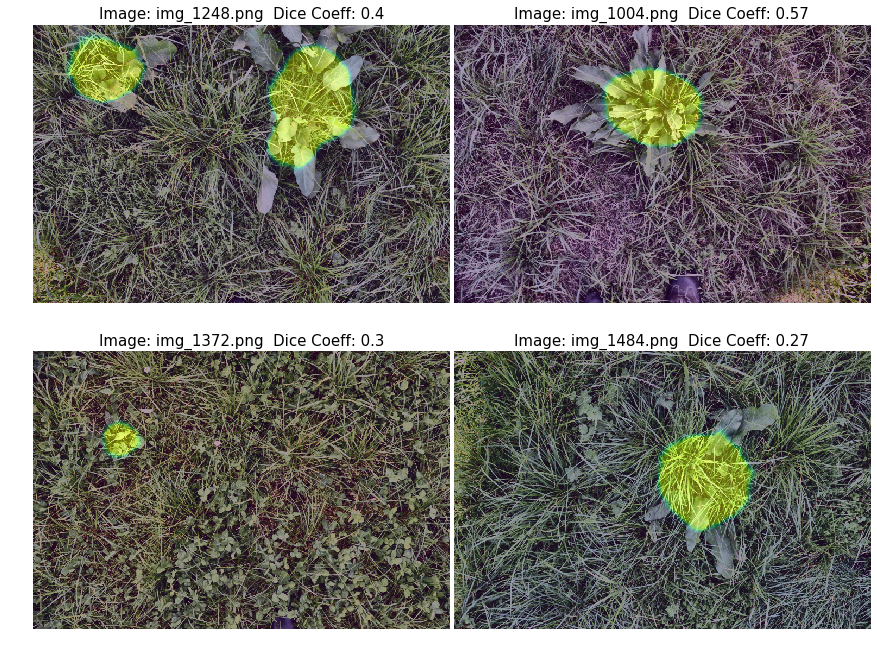

In [34]:
visualize.show_matrix(index='random',mode='image_prediction',rows=2)

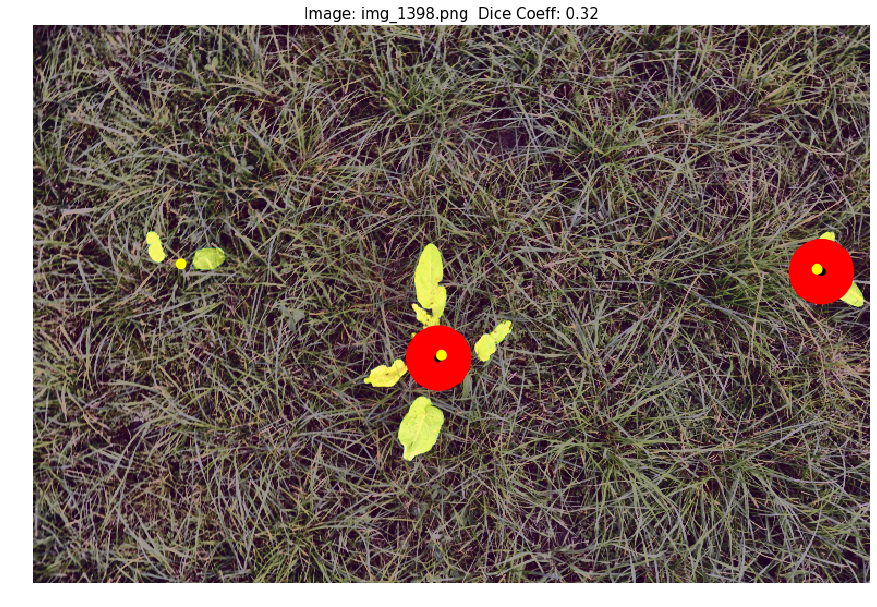

In [28]:
vis_params = {'df':val_df,
              'input_shape':(512,768,3),
              'pred_layer':2,
              'model':model}

root_pred = Visualize(**vis_params)
#img_1114
root_pred.show_single("1398",mode="image_prediction_roots")

### 3.7 Visualize Error Mask

In [76]:
ev_params = {'df':val_df,
             'input_shape':(512,768,3),
             'pred_layer' : 1,
             'model':model}
ev = Evaluate(**ev_params)

Aufsummiern aller falsch detektieren Masken (False Positive + False Negative):

In [77]:
def predict_all_error(df):
    error_sum = np.zeros(SHAPE)
    for i, row in df.iterrows():
        err = ev.get_full_error_mask(index=row['name'])
        error_sum += err
    return error_sum

In [79]:
summed_mask_error = predict_all_error(val_df)

Visualisierung aller überlagerten False Positiv + False Negativ Masken:

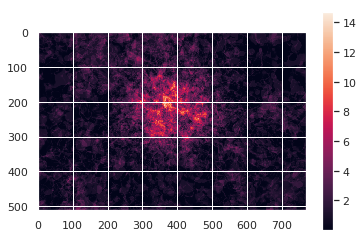

In [81]:
imshow(summed_mask_error)
plt.colorbar()

In [83]:
summed_mask_train = np.zeros((1024,1536))
for i,row in val_df.iterrows():
    summed_mask_train += rle_decode(row['mask_rle'],(1024,1536))
summed_mask_train = resize(summed_mask_train,(512,768))

Vergleich der summierten Trainingsmasken (Bild rechts) mit den summierten Falschen vorhersagen (Bild mitte). Das Bild rechts zeigt die subtraktion der normalisierten Trainingsmasken mit den normalisierten False Positiv + False Negativ:

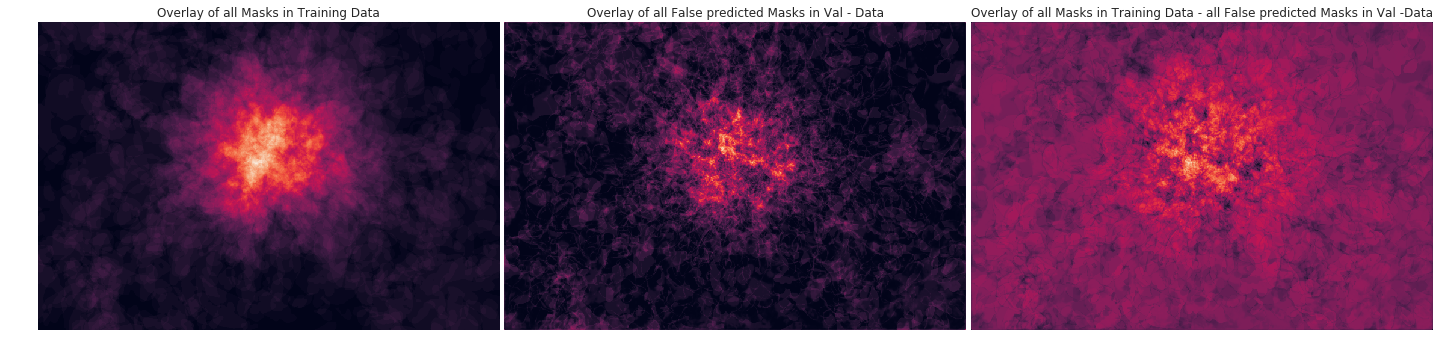

In [84]:
fig, axs = plt.subplots(ncols=3,nrows=1,figsize=(25,18))
axs[0].imshow(summed_mask_train)
axs[1].imshow(summed_mask_error)
#axs[1,0].imshow(summed_mask_train-summed_mask_error)
axs[2].imshow(summed_mask_train/summed_mask_train.max()-summed_mask_error/summed_mask_error.max())
axs[0].set_title('Overlay of all Masks in Training Data')
axs[0].axis('off')
axs[1].set_title('Overlay of all False predicted Masks in Val - Data')
axs[1].axis('off')
axs[2].set_title('Overlay of all Masks in Training Data - all False predicted Masks in Val -Data')
axs[2].axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0)

Die meisten falsch vohergesagten Masken befinden sich zwar im Zentrum der Bilder (wie die meisten Masken in den Trainingsbildern), jedoch sind diese besser Verteilt als die Ground Truth Masken. (Die Farbskalierung der Bilder ist bei beiden gleich) 
Daraus schliesse ich, das sich die Anhäufung der GroundTruth- Masken in den Trainingsdaten im Zentrum, negativ auf die vorhersagen von Blacken im Randbereich asuwirkt. d.h. es werden im Randbereich der Bilder überdurchschnittlich viele Blacken falsch vorhergesagt.